## Brain food

This example demonstrates convolutional neural networks for image classification using [TensorFlow](https://en.wikipedia.org/wiki/TensorFlow).  

The classification task is to discriminate real optical images of brain activity in mice from
fake images that were constructed using a [generative adversarial network (GAN)](https://en.wikipedia.org/wiki/Generative_adversarial_network).
A paper on the underlying imaging technologies developed by Yale researchers is [here](https://www.nature.com/articles/s41592-020-00984-6).

For this example we'll step you through the following steps:
* Downloading the data
* Loading the data
* Displaying some sample images
* Building a classification model using a simple CNN

After this, your task will be to improve upon this baseline model by building, training, and evaluating two more CNNs.



###  Downloading the data

The data are contained in a group of compressed files on AWS. There are 10 files of real images,
and 10 files of fake images; each file is roughly 100 MB in size; so the entire dataset is about 2 GB.
You should download the data to the computer you are running on, and place the in a folder named "data".

*Important note:* If you do not have enough space to download all of the data, just download what you can;
there will be no penalty for running on less data. If you want assistance running in Google Colab, please let us know.

Here are URLs to access the 20 data files:


https://sds365.s3.amazonaws.com/calcium/real_0.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_1.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_2.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_3.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_4.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_5.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_6.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_7.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_8.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_9.gz <br>


https://sds365.s3.amazonaws.com/calcium/fake_0.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_1.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_2.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_3.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_4.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_5.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_6.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_7.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_8.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_9.gz <br>




We import some Python packages from TensorFlow and Keras.

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import gzip
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.19.0'

Some helper functions for reading the data and plotting images.

In [27]:
def plot_images(imgs, title):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs[i], cmap='rainbow')
        plt.axis('off')
    plt.suptitle(title)

def read_gz(filedir, shape=[-1,128,128]):
    print('reading %s' % filedir)
    with gzip.open(filedir, 'rb') as f:
        content = f.read()
    imgs = np.frombuffer(content, dtype='float32').reshape(shape)
    return imgs

def load_data(dir, pieces):
    data = []
    label = []
    print('Loading data:\n-------------')
    for i in pieces:
        real_img = read_gz(dir + 'real_{:d}.gz'.format(i), shape=[-1,128,128, 1])
        fake_img = read_gz(dir + 'fake_{:d}.gz'.format(i), shape=[-1,128,128, 1])
        real_label = np.zeros((real_img.shape[0],1))
        fake_label = np.zeros((fake_img.shape[0],1))
        real_label[:,0] = 0
        fake_label[:,0] = 1
        data.append(real_img)
        data.append(fake_img)
        label.append(real_label)
        label.append(fake_label)
    print()
    data_all = np.concatenate(data, axis=0)
    label_all = np.concatenate(label, axis=0)
    return data_all, label_all



### Loading the data

Let's look at some images.

In [28]:
import os
# Mount Google Drive
from google.colab import drive
if not os.path.ismount("/content/drive"):
  drive.mount("/content/drive")

ROOT = "/content/drive/MyDrive/calcium/data/"


In [24]:
real_images = read_gz(ROOT + 'real_0.gz')
fake_images = read_gz(ROOT + 'fake_0.gz')

# real_img are original data, fake_img are synthetic data generated using a GAN model


reading /content/drive/MyDrive/calcium/data/real_0.gz
reading /content/drive/MyDrive/calcium/data/fake_0.gz


Each of the images is 128x128 pixels, and there are 2048 images in each file:

In [25]:
real_images.shape, fake_images.shape

((2048, 128, 128), (2048, 128, 128))

### Displaying some sample images

Now we'll display some real and fake images. Can you spot any differences between the two. Do you think that you could learn to tell them apart?

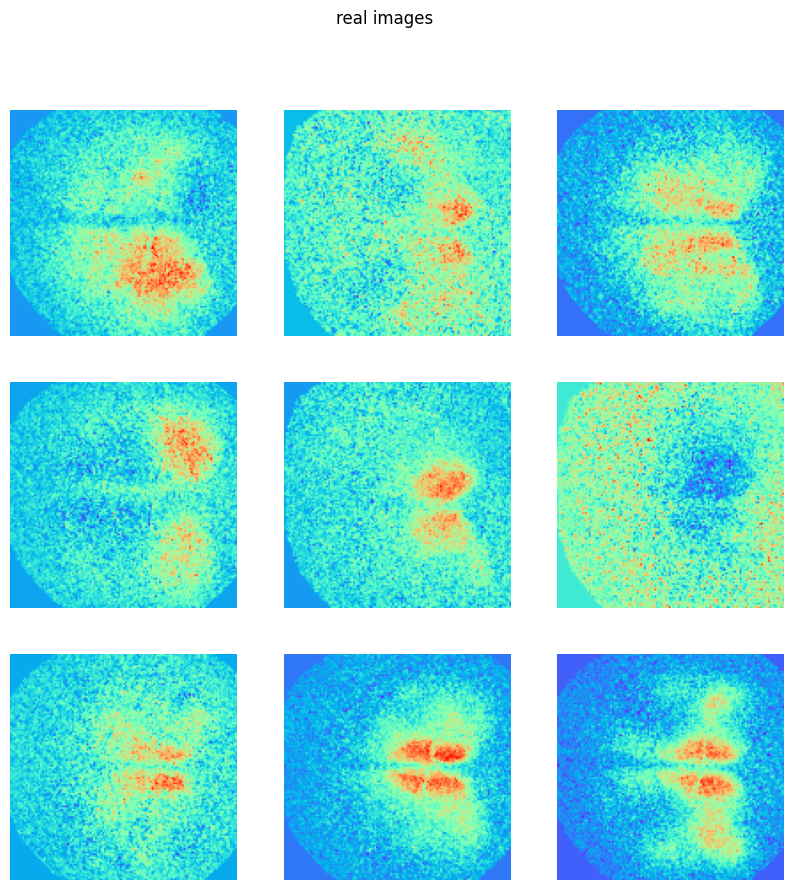

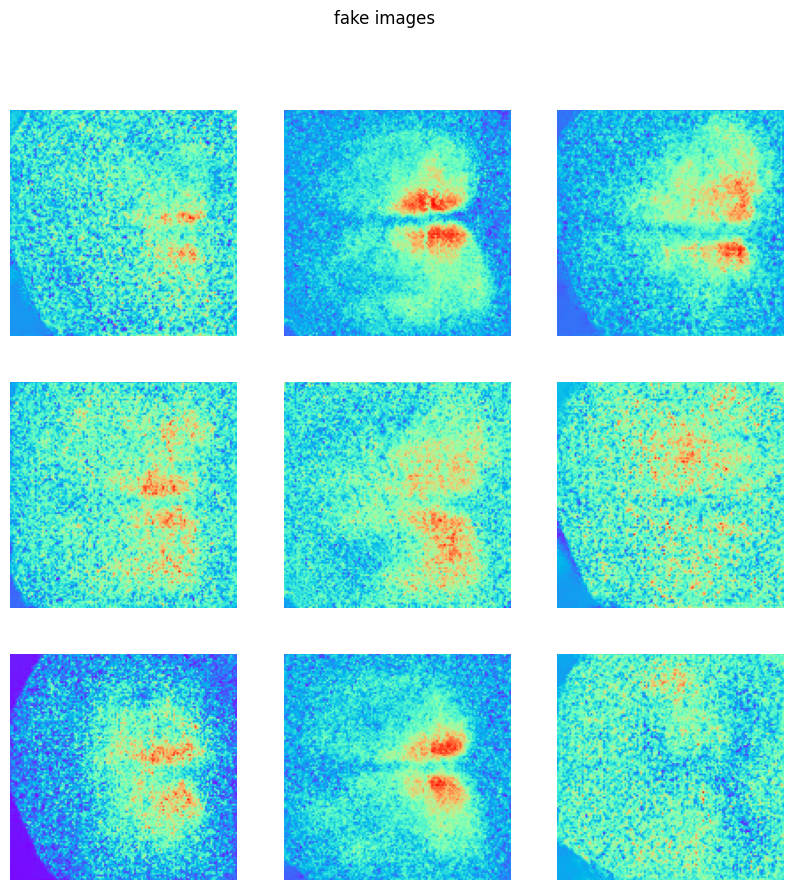

In [26]:
plot_images(real_images, 'real images')
plot_images(fake_images, 'fake images')

### 4.1 Building a baseline model

The code below trains and evaluates a baseline model. The model is trained on six of the data files (3 real, and 3 fake, about 12,000 images total) and is tested on six of the data files.
We begin by loading in the data.


In [29]:
train_images, train_labels = load_data(ROOT, [0,1,2])
test_images, test_labels = load_data(ROOT, [7,8,9])

Loading data:
-------------
reading /content/drive/MyDrive/calcium/data/real_0.gz
reading /content/drive/MyDrive/calcium/data/fake_0.gz
reading /content/drive/MyDrive/calcium/data/real_1.gz
reading /content/drive/MyDrive/calcium/data/fake_1.gz
reading /content/drive/MyDrive/calcium/data/real_2.gz
reading /content/drive/MyDrive/calcium/data/fake_2.gz

Loading data:
-------------
reading /content/drive/MyDrive/calcium/data/real_7.gz
reading /content/drive/MyDrive/calcium/data/fake_7.gz
reading /content/drive/MyDrive/calcium/data/real_8.gz
reading /content/drive/MyDrive/calcium/data/fake_8.gz
reading /content/drive/MyDrive/calcium/data/real_9.gz
reading /content/drive/MyDrive/calcium/data/fake_9.gz



Next, we initialize our convolutional neural network. This particular network has four layers: A convolutional layer, a max pooling latter, a flattened layer, and a dense layer with two terminal neurons and no activation function. The total number of parameters in this network is 62,338.


In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Flatten())
model.add(layers.Dense(2))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        61,506 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,338 (243.51 KB)

 Trainable params: 62,338 (243.51 KB)

 Non-trainable params: 0 (0.00 B)

Next, we train the model. Here we just train for two "epochs", where each epoch scans through the
data in random order, processing a batch of images in each stochastic gradient descent step.


In [ ]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=2, validation_split=0.2, shuffle=True)

Epoch 1/2
308/308 ━━━━━━━━━━━━━━━━━━━━ 119s 379ms/step - accuracy: 0.8333 - loss: 0.3662 - val_accuracy: 0.9882 - val_loss: 0.0674
Epoch 2/2
261/308 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.9981 - loss: 0.0224

Finally, we evaluate the model on the test data (the last three segments of images: 7,8,9).

In [ ]:
est_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('test accuracy: {:.4f}'.format(test_acc))

384/384 - 8s - loss: 0.2191 - accuracy: 0.8670
test accuracy: 0.8670


### Your turn!

Your job is to improve upon this baseline model. You can extend this model in various ways:

* Train on more data (but always test on the same test set)
* Add more convolutional layers
* Add more dense layers, using an activation function
* Regularize using a dropout layer

For each model that you decide to train, describe how and why you built this model. For example, you can:

* Give a diagram showing the sequence of layers used;
* Explain your rationale for using each of the layers;
* Comment on the number of parameters used by the model, and which layers have the most parameters;
* Describe your findings on number of epochs and training data size;
* Comment on models you experimented with but did not include;
* Describe the increase or decrease in accuracy that resulted.

When we evaluate your notebook, we will look for (1) significant improvements in test accuracy (2) descriptions of your models that show understanding of how they work and why you chose a given architecture.


Here is one of many possibilities:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((4,4)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        4128      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                